In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from keras.layers import Dense, Input

sns.set(style="whitegrid")
np.random.seed(1)

data_df = pd.read_excel("env_data.xlsx")
data_df.head(10)

Using TensorFlow backend.


,Mean 060 (°C),54: TC_Smoke (°C),Mean 260 (°C),187: CO_room (ppm),labels
0,9.643126,8.613041,15.811310,695.565623,safe
1,9.638108,8.614577,15.810892,693.682888,safe
2,9.629587,8.612079,15.801705,686.368593,safe
3,9.633649,8.603408,15.804218,690.206866,safe
4,10.224093,8.608649,15.994501,704.980179,safe
5,10.219408,8.615795,15.989499,712.511560,safe
6,10.217823,8.618646,15.989075,699.620981,safe
7,10.214540,8.616767,15.991340,693.031189,safe
8,10.217280,8.616913,15.994165,707.225165,safe
9,10.240848,8.610246,15.905355,714.611821,safe


In [2]:
df = data_df.drop(['Mean 260 (°C)'], axis=1)
df

,Mean 060 (°C),54: TC_Smoke (°C),187: CO_room (ppm),labels
0,9.643126,8.613041,695.565623,safe
1,9.638108,8.614577,693.682888,safe
2,9.629587,8.612079,686.368593,safe
3,9.633649,8.603408,690.206866,safe
4,10.224093,8.608649,704.980179,safe
...,...,...,...,...
65885,762.177943,35.854659,561.929191,danger
65886,762.140202,35.787602,561.493785,danger
65887,762.108967,35.693921,579.051064,danger
65888,762.075566,35.595093,576.439508,danger


In [3]:
# Mapping non-numeric columnns (ie target column)
target_mapping = {'danger':2, 'caution':1, 'safe':0}

df['labels'] = df['labels'].map(target_mapping)

In [4]:
# Separating data & target information
X = df.iloc[:, :3]
y = df.iloc [:, 3]

In [5]:
X

,Mean 060 (°C),54: TC_Smoke (°C),187: CO_room (ppm)
0,9.643126,8.613041,695.565623
1,9.638108,8.614577,693.682888
2,9.629587,8.612079,686.368593
3,9.633649,8.603408,690.206866
4,10.224093,8.608649,704.980179
...,...,...,...
65885,762.177943,35.854659,561.929191
65886,762.140202,35.787602,561.493785
65887,762.108967,35.693921,579.051064
65888,762.075566,35.595093,576.439508


In [6]:
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()
scaler.fit(X)  
X_std = scaler.transform(X)
#X_test_std = scaler.transform(X_test)  # apply same transformation to test data


In [7]:
from sklearn.model_selection import train_test_split
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.1, random_state=1, shuffle=True)

# Autoencoder

In [8]:
from keras.layers.core import Dropout
## input layer 
input_layer = Input(shape=(3,))

## encoding part
encoded1 = Dense(8, activation='tanh', activity_regularizer=regularizers.l1(10e-4))(input_layer)
encoded2 = Dropout(0.5)(encoded1)
encoded3 = Dense(4, activation='tanh')(encoded2)
encoded4 = Dropout(0.5)(encoded3)
encoded5 = Dense(2, activation='tanh')(encoded4)

encoder = Model(input_layer, encoded5)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
Total params: 78
Trainable params: 78
Non-trainable params: 0
_______________________________________________________________

2022-10-28 19:52:19.043941: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 19:52:19.045054: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [9]:
#Ltent representation
encoded_df=encoder.predict(X_train)
encoded_df

array([[-0.74843097, -0.5779573 ],
       [-0.7285307 , -0.6415147 ],
       [ 0.45297492,  0.10303538],
       ...,
       [ 0.39870065,  0.05265153],
       [ 0.30703273,  0.35693157],
       [ 0.15918058, -0.10932223]], dtype=float32)

In [10]:
# decoding part
#decoder_input= Input(shape=(2,))
decoded1 = Dense(4, activation='tanh')(encoded5)
decoded2 = Dropout(0.5)(decoded1)
decoded3 = Dense(8, activation='tanh')(decoded2)
decoded4 = Dropout(0.5)(decoded3)
decoded = Dense(3, activation='sigmoid')(decoded4)

In [11]:
# autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history=autoencoder.fit(X_train, X_train,
                epochs=200,
                batch_size=1024,
                validation_data=(X_test, X_test))

Train on 59301 samples, validate on 6589 samples
Epoch 1/200
59301/59301 [==============================] - 1s 21us/step - loss: 4.3218 - val_loss: 3.8129
Epoch 2/200
59301/59301 [==============================] - 0s 6us/step - loss: 3.7105 - val_loss: 3.1923
Epoch 3/200
59301/59301 [==============================] - 0s 6us/step - loss: 3.1736 - val_loss: 2.6817
Epoch 4/200
59301/59301 [==============================] - 0s 6us/step - loss: 2.7244 - val_loss: 2.2914
Epoch 5/200
59301/59301 [==============================] - 0s 6us/step - loss: 2.3539 - val_loss: 1.9570
Epoch 6/200
59301/59301 [==============================] - 0s 6us/step - loss: 1.9877 - val_loss: 1.6592
Epoch 7/200
59301/59301 [==============================] - 0s 6us/step - loss: 1.6792 - val_loss: 1.3984
Epoch 8/200
59301/59301 [==============================] - 0s 6us/step - loss: 1.4293 - val_loss: 1.1655
Epoch 9/200
59301/59301 [==============================] - 0s 6us/step - loss: 1.2166 - val_loss: 0.9969
Epoch

Epoch 78/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7199 - val_loss: 0.6531
Epoch 79/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7173 - val_loss: 0.6445
Epoch 80/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7205 - val_loss: 0.6429
Epoch 81/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7178 - val_loss: 0.6369
Epoch 82/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7163 - val_loss: 0.6459
Epoch 83/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7206 - val_loss: 0.6490
Epoch 84/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7222 - val_loss: 0.6592
Epoch 85/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7153 - val_loss: 0.6591
Epoch 86/200
59301/59301 [==============================] - 0s 6us/step - loss: 0.7178 - val_loss: 0.6442
Epoch 87/200
59301/59301 [====================

In [12]:
autoencoder.predict(X_train)

array([[9.9999982e-01, 9.9992996e-01, 9.9913502e-01],
       [9.2701006e-01, 7.8303516e-01, 2.1881753e-01],
       [0.0000000e+00, 2.9802322e-07, 2.9802322e-08],
       ...,
       [0.0000000e+00, 5.9604645e-07, 5.9604645e-08],
       [6.4975023e-04, 8.2654357e-03, 7.2601438e-04],
       [0.0000000e+00, 1.5605093e-06, 1.5373887e-07]], dtype=float32)

In [13]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12  

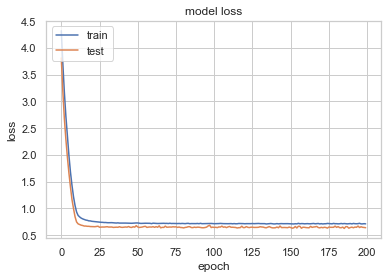

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# t-SNE

In [15]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [16]:
from sklearn.manifold import TSNE
# We want to get TSNE embedding with 2 dimensions
n_components = 3
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(encoded_df)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 

/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(46123, 3)

/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


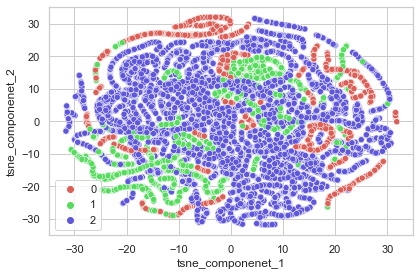

In [17]:
# split into input and output elements
#train, test = train_test_split(df, test_size=0.3)
label = y_train
#X = df.iloc[:, :3]
train = StandardScaler().fit_transform(encoded_df)

tsne = TSNE(n_components = 2, perplexity = 30.0, learning_rate= 200, random_state=1, n_iter=500)
tsne_res = tsne.fit_transform(train)

sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = label, palette = sns.hls_palette(3), legend = 'full');
plt.xlabel('tsne_componenet_1')
plt.ylabel('tsne_componenet_2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('TSNE.png', dpi=300, bbox_inches='tight')
plt.show()

# Artificial Neural Network

In [18]:
#Importing libraries
import pandas as pd 
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
import sklearn.metrics as metrics
import tensorflow.keras as keras
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import class_weight
from pandas import read_csv
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [19]:
train_x

array([[-0.8174381 , -0.764784  ],
       [ 0.4511295 ,  0.2691833 ],
       [ 0.3642729 ,  0.03227352],
       ...,
       [ 0.14729878, -0.11525568],
       [ 0.43955553,  0.08355644],
       [ 0.53080744,  0.24099329]], dtype=float32)

In [20]:
#encode the labels
y_train_onehot = keras.utils.to_categorical(train_y)
y_test_onehot = keras.utils.to_categorical(val_y)

In [21]:
classifier = Sequential()
#classifier.add(tf.keras.Input(shape=(3,)))
# input layer
classifier.add(Dense(units = 2, activation="tanh",activity_regularizer=regularizers.l2(10e-4), input_dim=2))
#Dropout(ignore some neurons) to prevent overfitting
classifier.add(Dropout(0.5))

# first hidden layer
classifier.add(Dense(units = 4, activation="tanh"))
#Dropout(ignore some neurons) to prevent overfitting
classifier.add(Dropout(0.5))

# second hidden layer
classifier.add(Dense(units = 8, activation="tanh"))
#Dropout(ignore some neurons) to prevent overfitting
classifier.add(Dropout(0.5))

# third hidden layer
classifier.add(Dense(units = 4, activation="tanh"))
#Dropout(ignore some neurons) to prevent overfitting
classifier.add(Dropout(0.5))

# output layer - units is 3 because we have three outputs
classifier.add(Dense(units = 3, activation="softmax"))

opt = keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=False)

#opt=tf.keras.optimizers.Adam(
    #learning_rate=0.006, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    #name='Adam'
#)

#classifier.compile(optimizer = opt, loss="categorical_crossentropy",metrics=["accuracy"])
classifier.compile(optimizer = opt, loss="categorical_crossentropy", metrics=["accuracy"])


#Apply early stop for the epochs
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose=0, patience=25)


#Fit the dataset to the ANN model
history=classifier.fit(train_x, y_train_onehot, batch_size=50, epochs=100, verbose=0, callbacks=[early_stop], validation_split=(0.1))

#calculate and print the metrics
pred_train= classifier.predict(train_x)
scores = classifier.evaluate(train_x, y_train_onehot, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= classifier.predict(val_x)
scores2 = classifier.evaluate(val_x, y_test_onehot, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    


Accuracy on training data: 0.8059583902359009% 
 Error on training data: 0.19404160976409912
Accuracy on test data: 0.8085795044898987% 
 Error on test data: 0.19142049551010132


test loss, test acc: [0.5449980105744929, 0.8085795]


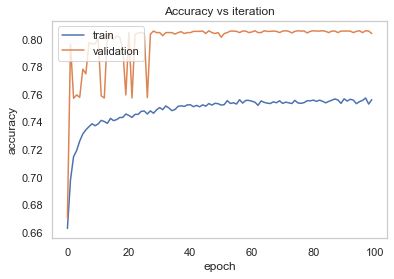

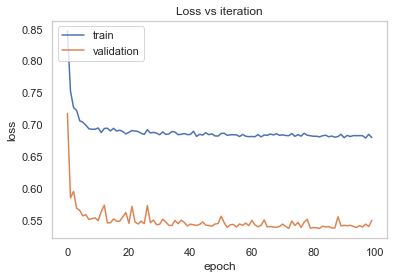

In [22]:
# Evaluate the model on the test data using `evaluate`
results = classifier.evaluate(val_x, y_test_onehot, batch_size=90, verbose=0)
print("test loss, test acc:", results)


# Plot the training and validation accuracies vs. epochs for the latest loop iteration
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs iteration')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.show()
# Save plot as PNG file
fig.savefig('Accuracy_Curves_ANN.png')


# Plot the training and validation losses vs. epochs for the latest loop iteration
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs iteration')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.show()
# Save plot as PNG file
fig.savefig('Loss_Curves_ANN.png')

In [23]:
#Confusion matrix
y_test_pred = classifier.predict_classes(val_x, verbose=0)
class_names = np.unique(y_test)
confmat = confusion_matrix(y_true=val_y, y_pred=y_test_pred, labels=class_names)
print(confmat)


[[ 1947     0   170]
 [  261     0  2402]
 [    5     0 10041]]


Misclassified samples: 2838
              precision    recall  f1-score   support

        safe       0.88      0.92      0.90      2117
     caution       0.00      0.00      0.00      2663
      danger       0.80      1.00      0.89     10046

    accuracy                           0.81     14826
   macro avg       0.56      0.64      0.60     14826
weighted avg       0.67      0.81      0.73     14826



/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

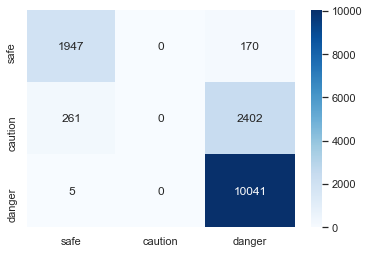

In [24]:
categories = ['safe', 'caution', 'danger']
sns.heatmap(confmat, annot=True, fmt="d",cmap='Blues', xticklabels= categories, yticklabels=categories)

print('Misclassified samples: %d' % (y_test_pred != val_y).sum())

from sklearn.metrics import classification_report
target_names = ['safe', 'caution', 'danger']
print(classification_report(val_y, y_test_pred, target_names=target_names))


# Test

In [106]:
# Importing the dataset
#Downloading the dataset, creating dataframe
df2 = pd.read_excel("Exp2_mean.xlsx")
df2 = df2.drop(['Mean 260 (°C)'], axis=1)

In [107]:
# Mapping non-numeric columnns (ie target column)
target_mapping = {'danger':2, 'caution':1, 'safe':0}

df2['labels'] = df2['labels'].map(target_mapping) 

# Separating data & target information
X2 = df2.iloc[:, :3]
y2 = df2.iloc [:, -1]

In [108]:
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()
scaler.fit(X2)  
X_std2 = scaler.transform(X2)
#X_test_std = scaler.transform(X_test)  # apply same transformation to test data


In [109]:
from sklearn.model_selection import train_test_split
from collections import Counter
X1_train, X1_test, y1_train, y1_test = train_test_split(X_std2, y2, test_size=0.1, random_state=1, shuffle=True)
print(f"Training target statistics: {Counter(y1_train)}")
print(f"Testing target statistics: {Counter(y1_test)}")

Training target statistics: Counter({2: 8999, 1: 3663, 0: 2182})
Testing target statistics: Counter({2: 996, 1: 403, 0: 251})


In [110]:
X1_train_encode=encoder.predict(X1_train)
X1_test_encode=encoder.predict(X1_test)

In [111]:
X1_train_encode

array([[ 0.06821505, -0.02228613],
       [ 0.06683713, -0.02360401],
       [ 0.06847402, -0.02203787],
       ...,
       [ 0.04785931, -0.0417248 ],
       [ 0.07126314, -0.01936898],
       [ 0.09156717,  0.00010847]], dtype=float32)

In [112]:
#encode the labels
y1_train_onehot = keras.utils.to_categorical(y1_train)
y1_test_onehot = keras.utils.to_categorical(y1_test)

In [113]:
#calculate and print the metrics
pred1_train= classifier.predict(X1_train_encode)
scores = classifier.evaluate(X1_train_encode, y1_train_onehot, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred1_test= classifier.predict(X1_test_encode)
scores3 = classifier.evaluate(X1_test_encode, y1_test_onehot, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    


Accuracy on training data: 0.6062381863594055% 
 Error on training data: 0.3937618136405945
Accuracy on test data: 0.7759341597557068% 
 Error on test data: 0.2240658402442932


In [114]:
#Confusion matrix
y1_test_pred = classifier.predict_classes(X1_train_encode, verbose=0)
class_names = np.unique(y1_train)
confmat = confusion_matrix(y_true=y1_train, y_pred=y1_test_pred, labels=class_names)
print(confmat)



[[   0    0 2182]
 [   0    0 3663]
 [   0    0 8999]]


Misclassified samples: 5845
              precision    recall  f1-score   support

        safe       0.00      0.00      0.00      2182
     caution       0.00      0.00      0.00      3663
      danger       0.61      1.00      0.75      8999

    accuracy                           0.61     14844
   macro avg       0.20      0.33      0.25     14844
weighted avg       0.37      0.61      0.46     14844



/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

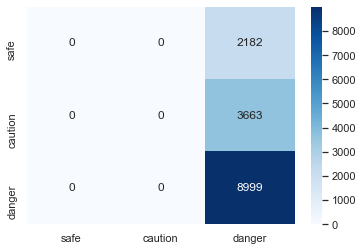

In [115]:
categories = ['safe', 'caution', 'danger']
sns.heatmap(confmat, annot=True, fmt="d",cmap='Blues', xticklabels= categories, yticklabels=categories)

print('Misclassified samples: %d' % (y1_test_pred != y1_train).sum())

from sklearn.metrics import classification_report
target_names = ['safe', 'caution', 'danger']
print(classification_report(y1_train, y1_test_pred, target_names=target_names))
